In [2]:
import json
import sqlalchemy
from database import engine

json_file_path = f"./data/spotify-data/data/liked-songs.json"
with open(json_file_path, "r", encoding="utf-8") as json_file:
    liked_songs = json.load(json_file)

with engine.begin() as conn:
    
    songs = []
    for song in liked_songs['items']:
        song_title = song['track']['name']
        artist_name = song['track']['artists'][0]['name']
        
        query = """
            SELECT spotify_name, musicbrainz_name
            FROM musicbrainz.name_map
            WHERE spotify_name = :artist
        """
        unknown = conn.execute(sqlalchemy.text(query), {"artist": artist_name}).mappings().one_or_none()
        
        if unknown is not None:
            if unknown['musicbrainz_name'] is None:
                continue
            else:
                artist_name = unknown['musicbrainz_name']
                
        songs.append({'title': song_title.split(' (')[0], 'artist': artist_name})
    
    orig_query = f"""
    CREATE MATERIALIZED VIEW musicbrainz.liked_songs AS (
        SELECT
            r.id AS recording_id,
            r.name AS name,
            a.id AS artist_credit,
            a.name AS artists
        FROM musicbrainz.recording r
        JOIN musicbrainz.artist_credit a ON a.id = r.artist_credit
        WHERE (r.name = :title AND a.name = :artist)
    )
    """
    conditions = " OR ".join([f"(r.name = :title{i} AND a.name ILIKE :artist{i})" for i in range(len(songs))])
    full_query = orig_query.replace("(r.name = :title AND a.name = :artist)", conditions)

    params = {f"title{i}": song["title"] for i, song in enumerate(songs)}
    params.update({f"artist{i}": song["artist"] for i, song in enumerate(songs)})
    
    conn.execute(sqlalchemy.text(full_query), params)

In [76]:
import json
import polars as pl
from datetime import datetime

json_file_path = f"./data/spotify-data/data/liked-songs.json"
with open(json_file_path, "r", encoding="utf-8") as file:
    songs = json.load(file)

song_data = pl.DataFrame(songs['items'])
song_data = song_data.unnest("track")

album_data = pl.DataFrame(song_data.select(pl.col("album")).unnest("album"))

song_data = song_data.drop(
    pl.col("available_markets"), 
    pl.col("preview_url"), 
    pl.col("external_ids"), 
    pl.col("href")
)
song_data = song_data.with_columns(
    pl.col("added_at").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%SZ")
)
print(song_data.limit(5))

album_data = album_data.drop(
    pl.col("available_markets"), 
    pl.col("external_urls"), 
    pl.col("images"), 
    pl.col("href"))
print(album_data.limit(5))
    
json_file_path = f"./data/spotify-data/data/liked-artists.json"
with open(json_file_path, "r", encoding="utf-8") as json_file:
    artists = json.load(json_file)
    
artist_data = pl.DataFrame(artists)
artist_data = artist_data.drop(pl.col("followers"), pl.col("external_urls"), pl.col("href"), pl.col("images"))
artist_data = artist_data.with_columns(
    pl.when(pl.col("genres").list.len() == 0).then(pl.lit(["unknown"])).otherwise(pl.col("genres")).alias("genres")
)
print(artist_data.limit(5))

shape: (5, 15)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────┬───────────┐
│ added_at   ┆ album      ┆ artists    ┆ disc_numb ┆ … ┆ popularit ┆ track_num ┆ type  ┆ uri       │
│ ---        ┆ ---        ┆ ---        ┆ er        ┆   ┆ y         ┆ ber       ┆ ---   ┆ ---       │
│ datetime[μ ┆ struct[14] ┆ list[struc ┆ ---       ┆   ┆ ---       ┆ ---       ┆ str   ┆ str       │
│ s]         ┆            ┆ t[6]]      ┆ i64       ┆   ┆ i64       ┆ i64       ┆       ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════╪═══════════╡
│ 2025-02-20 ┆ {"compilat ┆ [{{"https: ┆ 1         ┆ … ┆ 3         ┆ 1         ┆ track ┆ spotify:t │
│ 22:07:26   ┆ ion",[{{"h ┆ //open.spo ┆           ┆   ┆           ┆           ┆       ┆ rack:6oCo │
│            ┆ ttps://ope ┆ tify.com/a ┆           ┆   ┆           ┆           ┆       ┆ 9iflbbnlR │
│            ┆ …          ┆ …          ┆           ┆   ┆           ┆        

unknown songs shape: (1, 2)
┌─────────┬───────┐
│ genres  ┆ count │
│ ---     ┆ ---   │
│ str     ┆ u32   │
╞═════════╪═══════╡
│ unknown ┆ 1565  │
└─────────┴───────┘


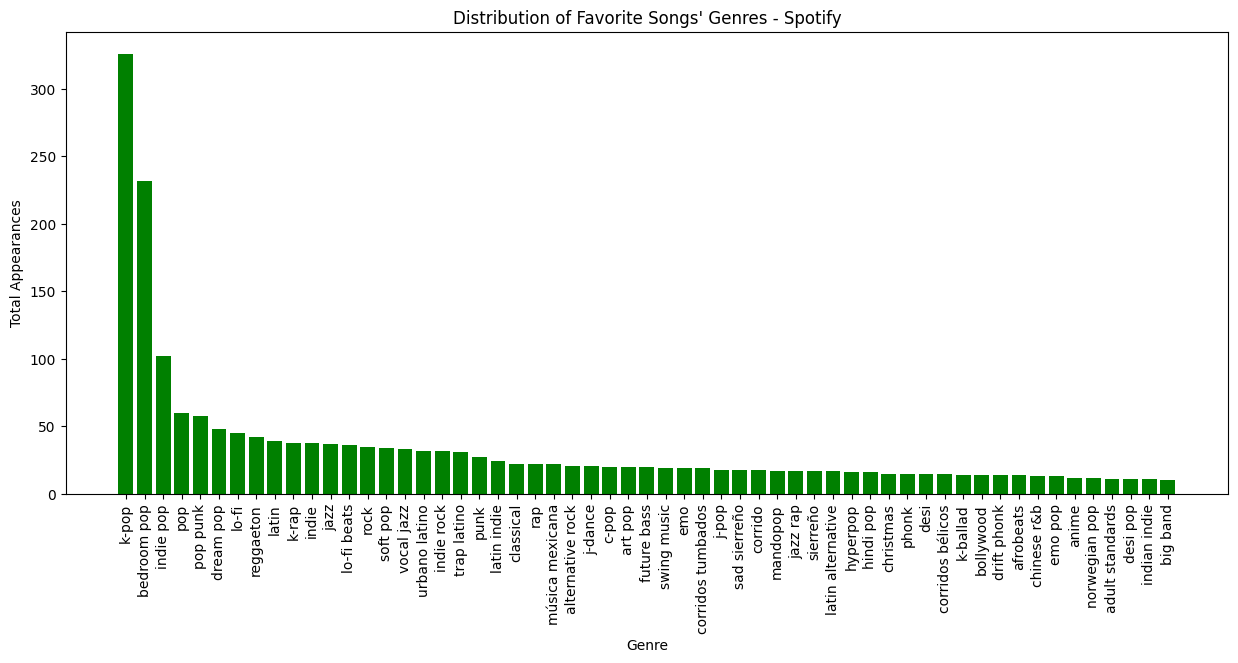

In [74]:
# Overall Genre Graph - Spotify

import matplotlib.pyplot as plt

genres = artist_data.explode("genres").select(pl.col("genres").value_counts(sort=True, name="count")).unnest("genres")

print("unknown songs", genres.filter(pl.col("genres") == "unknown"))

genres = genres.filter(pl.col("count") >= 10, pl.col("genres") != "unknown")

labels, values = genres["genres"].to_list(), genres["count"].to_list()

plt.figure(figsize=(15, 6))
plt.bar(labels, values, color="green")
plt.ylabel("Total Appearances")
plt.xlabel("Genre")
plt.xticks(rotation=90)
plt.title("Distribution of Favorite Songs' Genres - Spotify")
plt.show()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

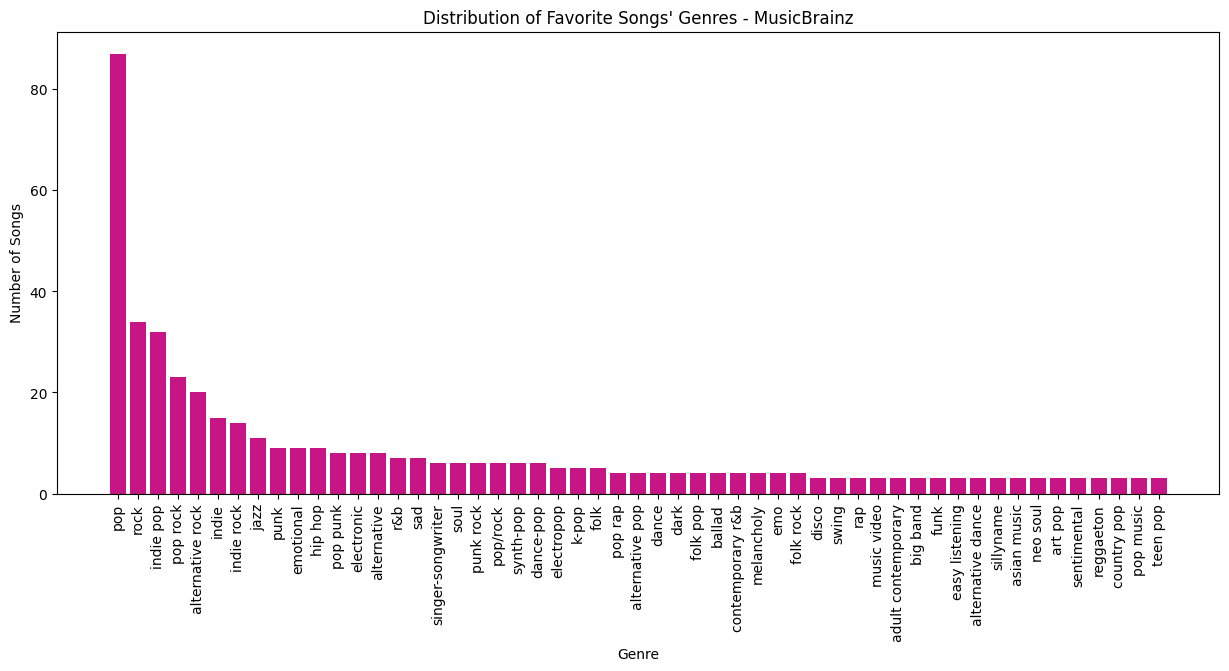

In [72]:
import duckdb

connection = duckdb.connect()

connection.execute("ATTACH 'host=localhost port=5432 user=postgres password=scary dbname=music' AS music_db (TYPE postgres)")
connection.execute("USE music_db.musicbrainz")

query = """
    SELECT t.name AS genre, COUNT(*) AS count
    FROM (
        SELECT DISTINCT ON (s.name, s.artist_credit, s.artists) 
            s.name, s.artist_credit, s.artists, s.recording_id
        FROM liked_songs s
        ORDER BY s.name, s.artist_credit, s.artists
    ) s
    LEFT JOIN recording_tag r ON s.recording_id = r.recording
    JOIN tag t ON t.id = r.tag
    GROUP BY t.name
    HAVING COUNT(*) >= 3
    ORDER BY COUNT(*) DESC
"""

df = connection.query(query).to_df()

plt.figure(figsize=(15, 6))
plt.bar(df["genre"], df["count"], color="mediumvioletred")
plt.ylabel("Number of Songs")
plt.xlabel("Genre")
plt.xticks(rotation=90)
plt.title("Distribution of Favorite Songs' Genres - MusicBrainz")
plt.show()

unknown songs in 2020 shape: (1, 2)
┌─────────┬───────┐
│ genres  ┆ count │
│ ---     ┆ ---   │
│ str     ┆ u32   │
╞═════════╪═══════╡
│ unknown ┆ 89    │
└─────────┴───────┘


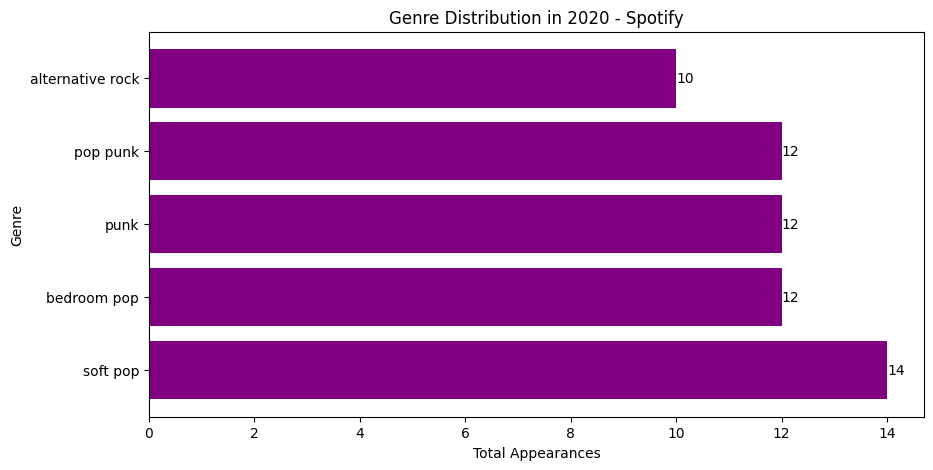

unknown songs in 2021 shape: (1, 2)
┌─────────┬───────┐
│ genres  ┆ count │
│ ---     ┆ ---   │
│ str     ┆ u32   │
╞═════════╪═══════╡
│ unknown ┆ 343   │
└─────────┴───────┘


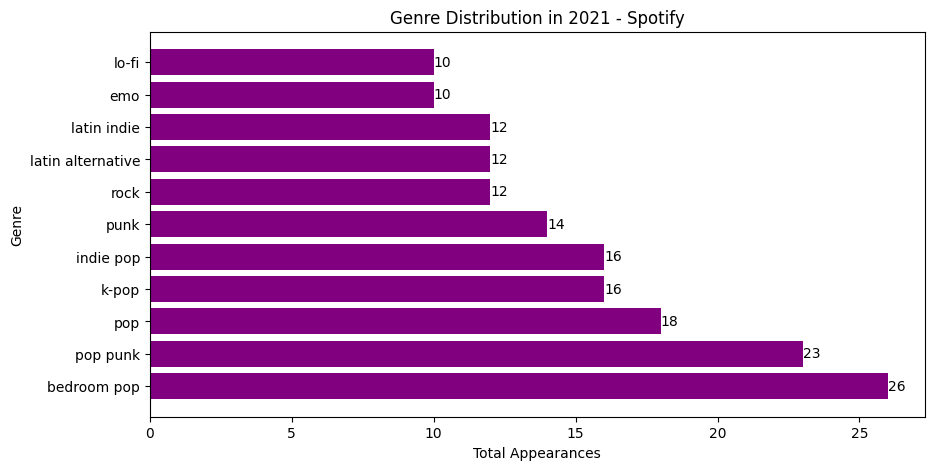

unknown songs in 2022 shape: (1, 2)
┌─────────┬───────┐
│ genres  ┆ count │
│ ---     ┆ ---   │
│ str     ┆ u32   │
╞═════════╪═══════╡
│ unknown ┆ 295   │
└─────────┴───────┘


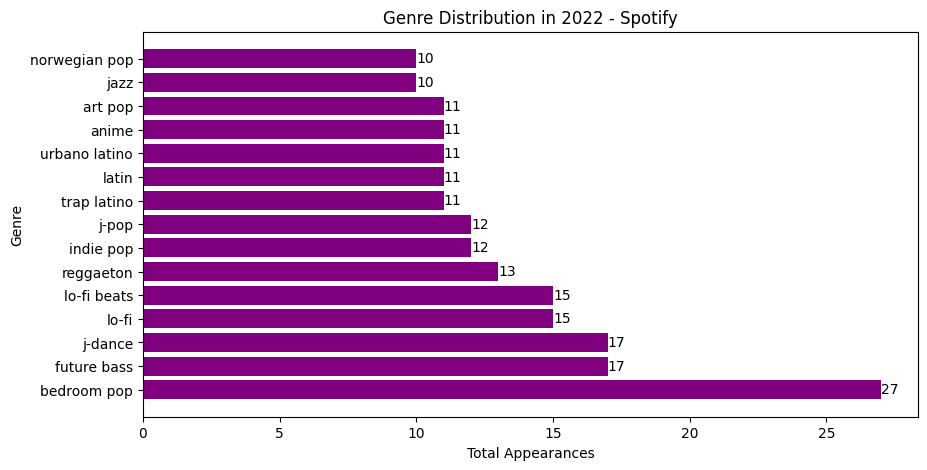

unknown songs in 2023 shape: (1, 2)
┌─────────┬───────┐
│ genres  ┆ count │
│ ---     ┆ ---   │
│ str     ┆ u32   │
╞═════════╪═══════╡
│ unknown ┆ 422   │
└─────────┴───────┘


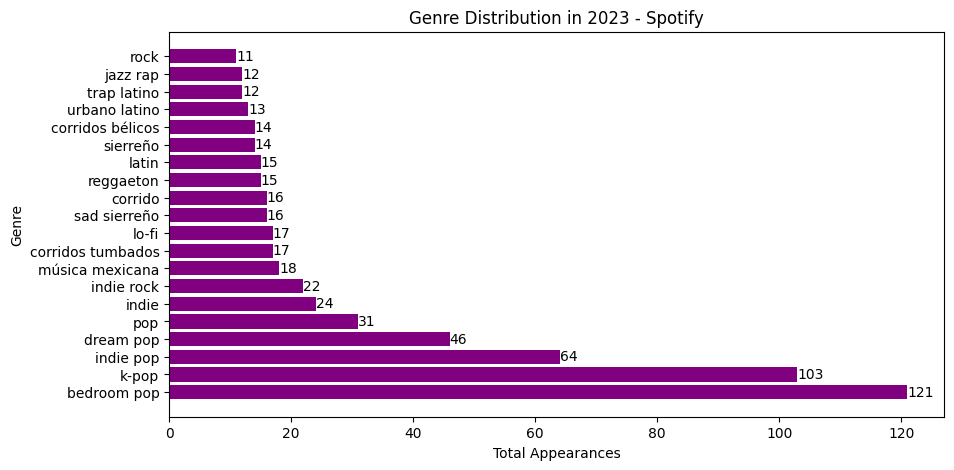

unknown songs in 2024 shape: (1, 2)
┌─────────┬───────┐
│ genres  ┆ count │
│ ---     ┆ ---   │
│ str     ┆ u32   │
╞═════════╪═══════╡
│ unknown ┆ 377   │
└─────────┴───────┘


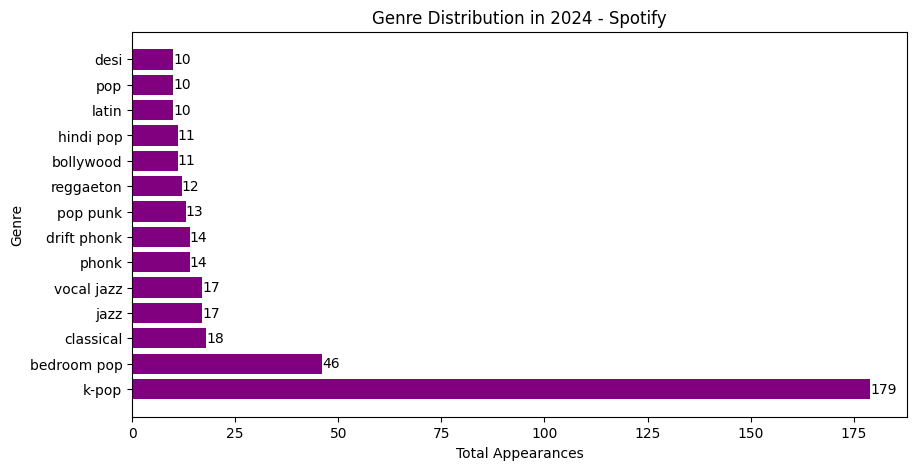

unknown songs in 2025 shape: (1, 2)
┌─────────┬───────┐
│ genres  ┆ count │
│ ---     ┆ ---   │
│ str     ┆ u32   │
╞═════════╪═══════╡
│ unknown ┆ 48    │
└─────────┴───────┘


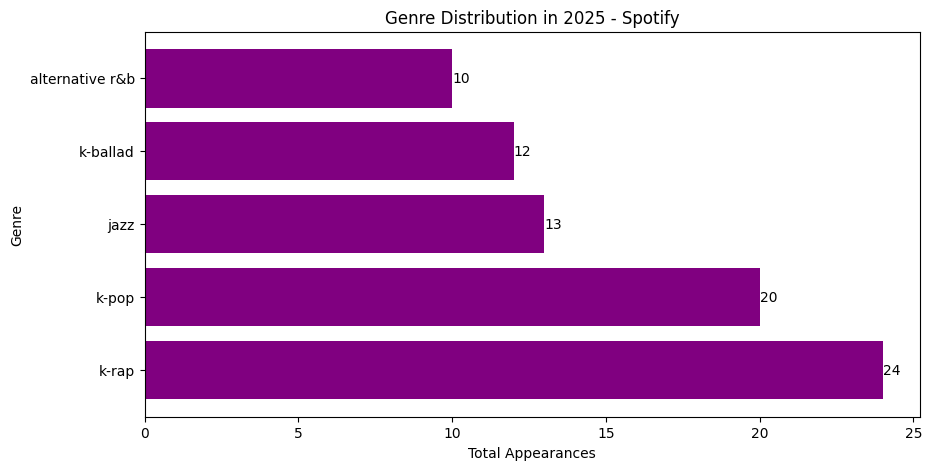

In [75]:
# Genre Graphs by Year - Spotify

import matplotlib.pyplot as plt

uniq_artists = artist_data.unique()

song_years = song_data.lazy().with_columns(
    pl.col("added_at").dt.year().alias("added_year")
).drop(pl.col("added_at"))

song_years = (
    song_years.select(
        pl.col("artists"),
        pl.col("added_year")
    )
).explode("artists").unnest("artists")

song_years = song_years.join(
    uniq_artists.lazy(), left_on="id", right_on="id", how="left"
).select(
    pl.col("genres"),
    pl.col("added_year")
)

song_years = song_years.collect()

for year in song_years["added_year"].unique().sort():
    yearly_data = song_years.filter(pl.col("added_year") == year)
    
    genres = (
        yearly_data.explode("genres") 
        .select(pl.col("genres").value_counts(sort=True, name="count"))
        .unnest("genres")
    )
    
    print("unknown songs in", year, genres.filter(pl.col("genres") == "unknown"))
    
    genres = genres.filter(pl.col("count") >= 10, pl.col("genres") != "unknown")

    labels, values = genres["genres"].to_list(), genres["count"].to_list()

    plt.figure(figsize=(10, 5))
    bars = plt.barh(labels, values, color="purple")

    for bar, value in zip(bars, values):
        plt.text(value, bar.get_y() + bar.get_height()/2, str(value), va='center', fontsize=10)

    plt.xlabel("Total Appearances")
    plt.ylabel("Genre")
    plt.title(f"Genre Distribution in {year} - Spotify")

    plt.show()

In [79]:
total_songs = pl.DataFrame(songs['items']).count()
print(total_songs)

total_artists = artist_data.unique().count()
print(total_artists)

shape: (1, 2)
┌──────────┬───────┐
│ added_at ┆ track │
│ ---      ┆ ---   │
│ u32      ┆ u32   │
╞══════════╪═══════╡
│ 2406     ┆ 2406  │
└──────────┴───────┘
shape: (1, 6)
┌────────┬──────┬──────┬────────────┬──────┬──────┐
│ genres ┆ id   ┆ name ┆ popularity ┆ type ┆ uri  │
│ ---    ┆ ---  ┆ ---  ┆ ---        ┆ ---  ┆ ---  │
│ u32    ┆ u32  ┆ u32  ┆ u32        ┆ u32  ┆ u32  │
╞════════╪══════╪══════╪════════════╪══════╪══════╡
│ 1138   ┆ 1138 ┆ 1138 ┆ 1138       ┆ 1138 ┆ 1138 │
└────────┴──────┴──────┴────────────┴──────┴──────┘
